# News analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
from wordcloud import WordCloud
import geopandas as gpd
import plotly.express as px

In [2]:
articles = pd.read_csv('helene_articles_20241114.csv')
articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...","October 2, 2024",Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,"October 2, 2024",Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,"October 2, 2024",Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,"October 2, 2024",Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat
4,"Charlotte Observer, The (NC): Page 1\nOctober ...","Citation (aglc Style)\nCharlotte Observer, The...","Charlotte Observer, The (NC): Page 1","October 2, 2024",Charlotte Observer,NaN,NaN,Mecklenburg,Charlotte Observer


## Cleaning

In [ ]:
# - date: string to date.time
articles['date'] = pd.to_datetime(articles['date'])

# - author & word_count: fill_na 
articles = articles.fillna('')

# Function to clean article texts
def clean_text(text):
    newspaper = articles.loc[articles['article'] == text,'newspaper'].iloc[0]
    # Remove "All rights reserved"
    text = re.sub(r"\n.*?All Rights Reserved\..*", "", text)
    text = re.sub(r"\n.*?All rights reserved\..*", "", text)
    # Remove "Citation (aglc Style)..." at the end of the articles
    text = re.sub(r"Citation \(aglc Style\)\n.*", "", text, flags=re.DOTALL)
    # Remove last news outlet occurance
    text = text.split(newspaper, -1)[0]
    # Convert to lowercase
    text = text.lower()  
    # Remove punctuation and special characters
    text = re.sub(r'\W+', ' ', text)  
    return text

articles['cleaned_article'] = articles['article'].apply(clean_text)

# Save it locally
# articles.to_csv('helene_articles_20241114.csv', index= False)
articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,cleaned_article
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",2024-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,boone samaritan s purse and alliance bible fel...
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,2024-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,attorney general josh stein declared the state...
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,2024-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,widespread power outages due to damage from hu...
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,2024-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,more than 300 line technicians consisting of b...
4,"Charlotte Observer, The (NC): Page 1\nOctober ...","Citation (aglc Style)\nCharlotte Observer, The...","Charlotte Observer, The (NC): Page 1",2024-10-02,Charlotte Observer,,,Mecklenburg,Charlotte Observer,


## Analysis

A few research questions to ask:
1. How has the coverage topic changed along time?
2. In which geographical areas are these coverages about, how local are these coverages?
3. service media: how much of them touched on action to do or support?
4. How satisfied are people in disaster about these coverages: survey?

### Coverage number changes

In [10]:
date = articles.groupby('date')['article'].count().reset_index()
date

,date,article
0,2024-09-23,2
1,2024-09-24,3
2,2024-09-25,17
3,2024-09-26,32
4,2024-09-27,40
5,2024-09-28,26
6,2024-09-29,43
7,2024-09-30,50
8,2024-10-01,86
9,2024-10-02,126


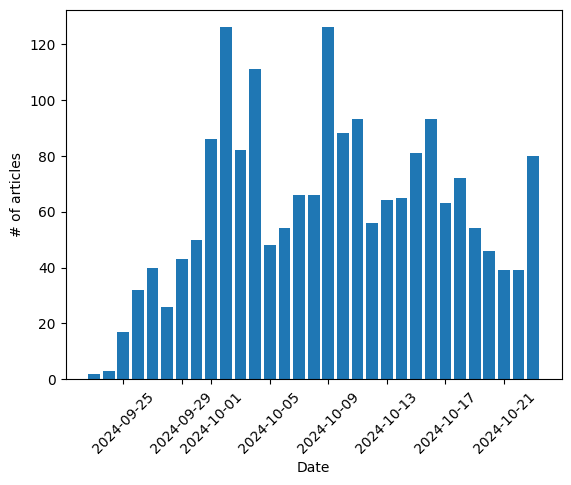

In [17]:
# Plotting the data
plt.bar(date['date'], date['article'])
plt.xlabel('Date')
plt.ylabel('# of articles')
plt.xticks(rotation=45)

# plt.title('')
plt.show()

### Word frenquency analysis

Before getting news articles texts for print, analyze only the subset of it with valid texts

In [54]:
sub_articles = articles[articles['word_count'] != '']
len(sub_articles)

1679

In [65]:
# Remove stop words

# Download stop words
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Another stop word set for news
stop_df = pd.read_csv('https://raw.githubusercontent.com/vikasing/news-stopwords/refs/heads/master/sw10k.csv')
stop_words.update(stop_df['term'].to_list())
stop_words.update(['2024', 'hurricane', 'helene'])


# Tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    return [word for word in words if word not in stop_words]

sub_articles['tokens'] = sub_articles['cleaned_article'].apply(tokenize_and_remove_stopwords)


[nltk_data] Downloading package punkt to /Users/yanans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/cn/fww9r0gd1mg20td4q8v12_lsknvlj7/T/ipykernel_14443/2465098581.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_articles['tokens'] = sub_articles['cleaned_article'].apply(tokenize_and_remove_stopwords)


In [67]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Stem the tokens
sub_articles['stemmed_tokens'] = sub_articles['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])


/var/folders/cn/fww9r0gd1mg20td4q8v12_lsknvlj7/T/ipykernel_14443/4228210856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_articles['stemmed_tokens'] = sub_articles['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])


In [68]:
# Flatten all tokens into a single list and count frequencies
all_tokens = [token for tokens in sub_articles['tokens'] for token in tokens]
word_freq = Counter(all_tokens)
print(word_freq.most_common(50))  # Display the 10 most common words

[('asheville', 1531), ('fema', 1412), ('nc', 1378), ('watauga', 843), ('mcdowell', 768), ('haywood', 669), ('boone', 529), ('marion', 486), ('hendersonville', 471), ('catawba', 434), ('buncombe', 425), ('caldwell', 390), ('waynesville', 388), ('devastation', 386), ('morganton', 383), ('henderson', 372), ('tryon', 365), ('canton', 346), ('outages', 309), ('rutherford', 301), ('downed', 297), ('polk', 292), ('biden', 267), ('baptist', 265), ('touchdown', 255), ('828', 254), ('gaston', 244), ('chimney', 224), ('swannanoa', 223), ('mountaineer', 218), ('hurricanes', 217), ('responders', 217), ('hickory', 216), ('ashe', 214), ('bulletin', 214), ('publications', 213), ('avery', 206), ('halloween', 205), ('appalachian', 202), ('pisgah', 200), ('biltmore', 190), ('wnc', 190), ('cleanup', 189), ('cherokee', 180), ('landslides', 172), ('clyde', 172), ('milton', 166), ('absentee', 164), ('touchdowns', 163), ('3a', 160)]


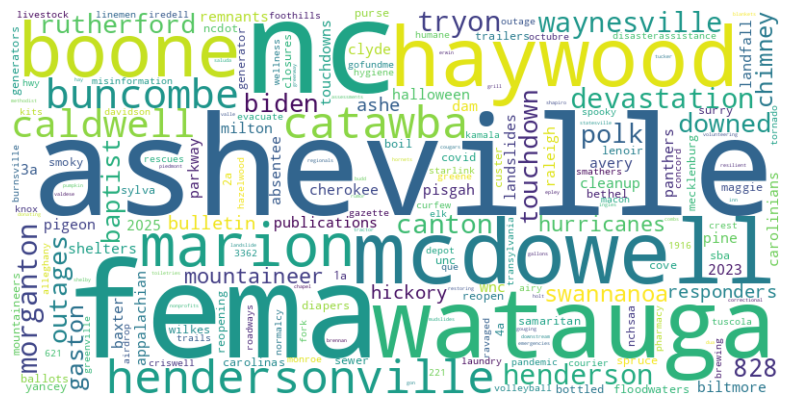

In [69]:
# Create the word cloud from the frequency dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Most frequent words are county names / locations. Others are description of the disaster such as "devastation", "outages", "downed", "landslides", ...

Something that didn't make sense: "baptist", "touchdown(s)"

### Topic modeling

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(articles['token'])
corpus = [dictionary.doc2bow(tokens) for tokens in articles['token']]

# Build the LDA model
lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# Print topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

### Geographical Mapping

Of newspaper publications & of coverage

In [ ]:
# Article publication by county
sub_articles = articles[articles['word_count'] != '']

counties = sub_articles.groupby('County')['article'].count().reset_index()
counties

,County,article
0,Burke,119
1,Caldwell,74
2,Cleveland,71
3,Gaston,69
4,Haywood,176
5,Henderson,180
6,Jackson,30
7,McDowell,137
8,Mecklenburg,336
9,Polk,99


In [ ]:
# Import geojson data
us_counties = gpd.read_file("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json")
nc_counties = us_counties[us_counties['STATE'] == '37']     # NC only

nc_counties.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
387,37001,0500000US37001,37,001,Alamance,County,423.943,"POLYGON ((-79.25948 36.13727, -79.24948 35.876..."
388,37005,0500000US37005,37,005,Alleghany,County,235.059,"POLYGON ((-81.35317 36.57472, -81.30751 36.575..."
389,37017,0500000US37017,37,017,Bladen,County,874.328,"POLYGON ((-78.25632 34.39976, -78.33725 34.367..."
390,37021,0500000US37021,37,021,Buncombe,County,656.672,"POLYGON ((-82.16902 35.52784, -82.26685 35.465..."
391,37027,0500000US37027,37,027,Caldwell,County,471.566,"POLYGON ((-81.33426 35.79646, -81.34634 35.794..."


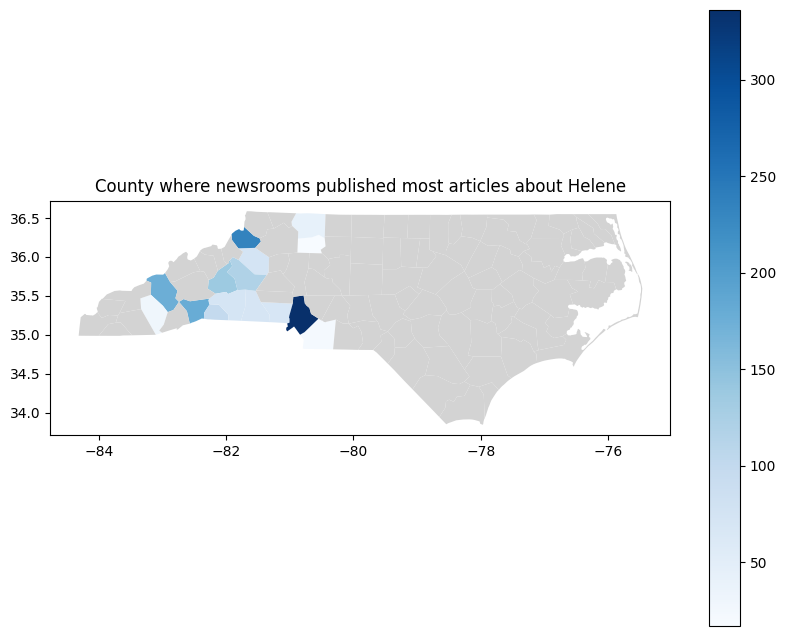

In [14]:
merged = nc_counties.merge(counties, left_on='NAME', right_on='County', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='article', ax=ax, legend=True, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"})
plt.title("County where newsrooms published most articles about Helene")
plt.show()

Which county is mentioned the most in Helene coverage?

In [74]:
# Get a list of counties
c_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()

def detect_county(text):
    for county in c_list:
        if county in text:
            if county in c_dict.keys():
                c_dict[county] +=1
            else:
                c_dict[county] = 1

c_dict = {}
sub_articles['cleaned_article'].apply(detect_county)
c_df = pd.DataFrame(list(c_dict.items()), columns=['County', 'coverage'])
c_df


,County,coverage
0,avery,145
1,franklin,26
2,graham,27
3,lee,175
4,wake,219
...,...,...
91,bladen,2
92,hertford,1
93,duplin,1
94,pasquotank,1


/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



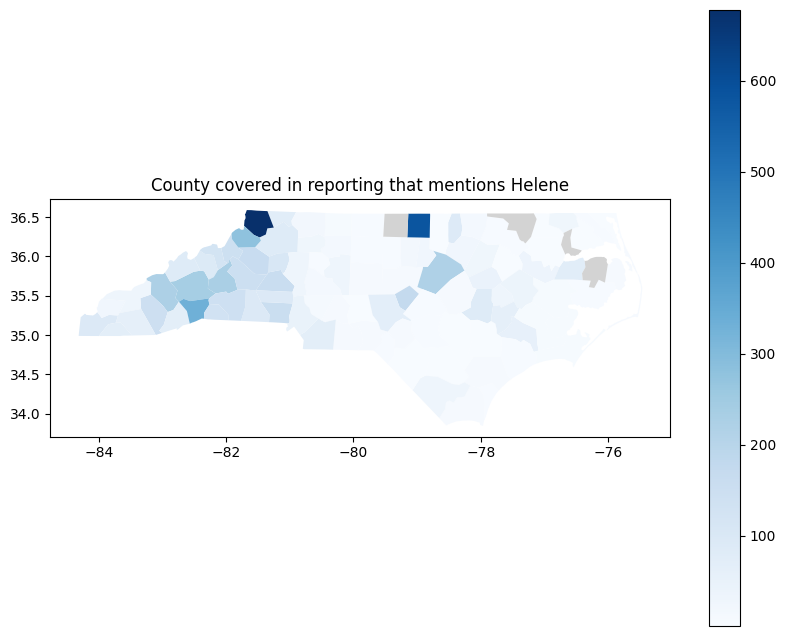

In [76]:
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='coverage', ax=ax, legend=True, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"})
plt.title("County covered in reporting that mentions Helene")
plt.show()

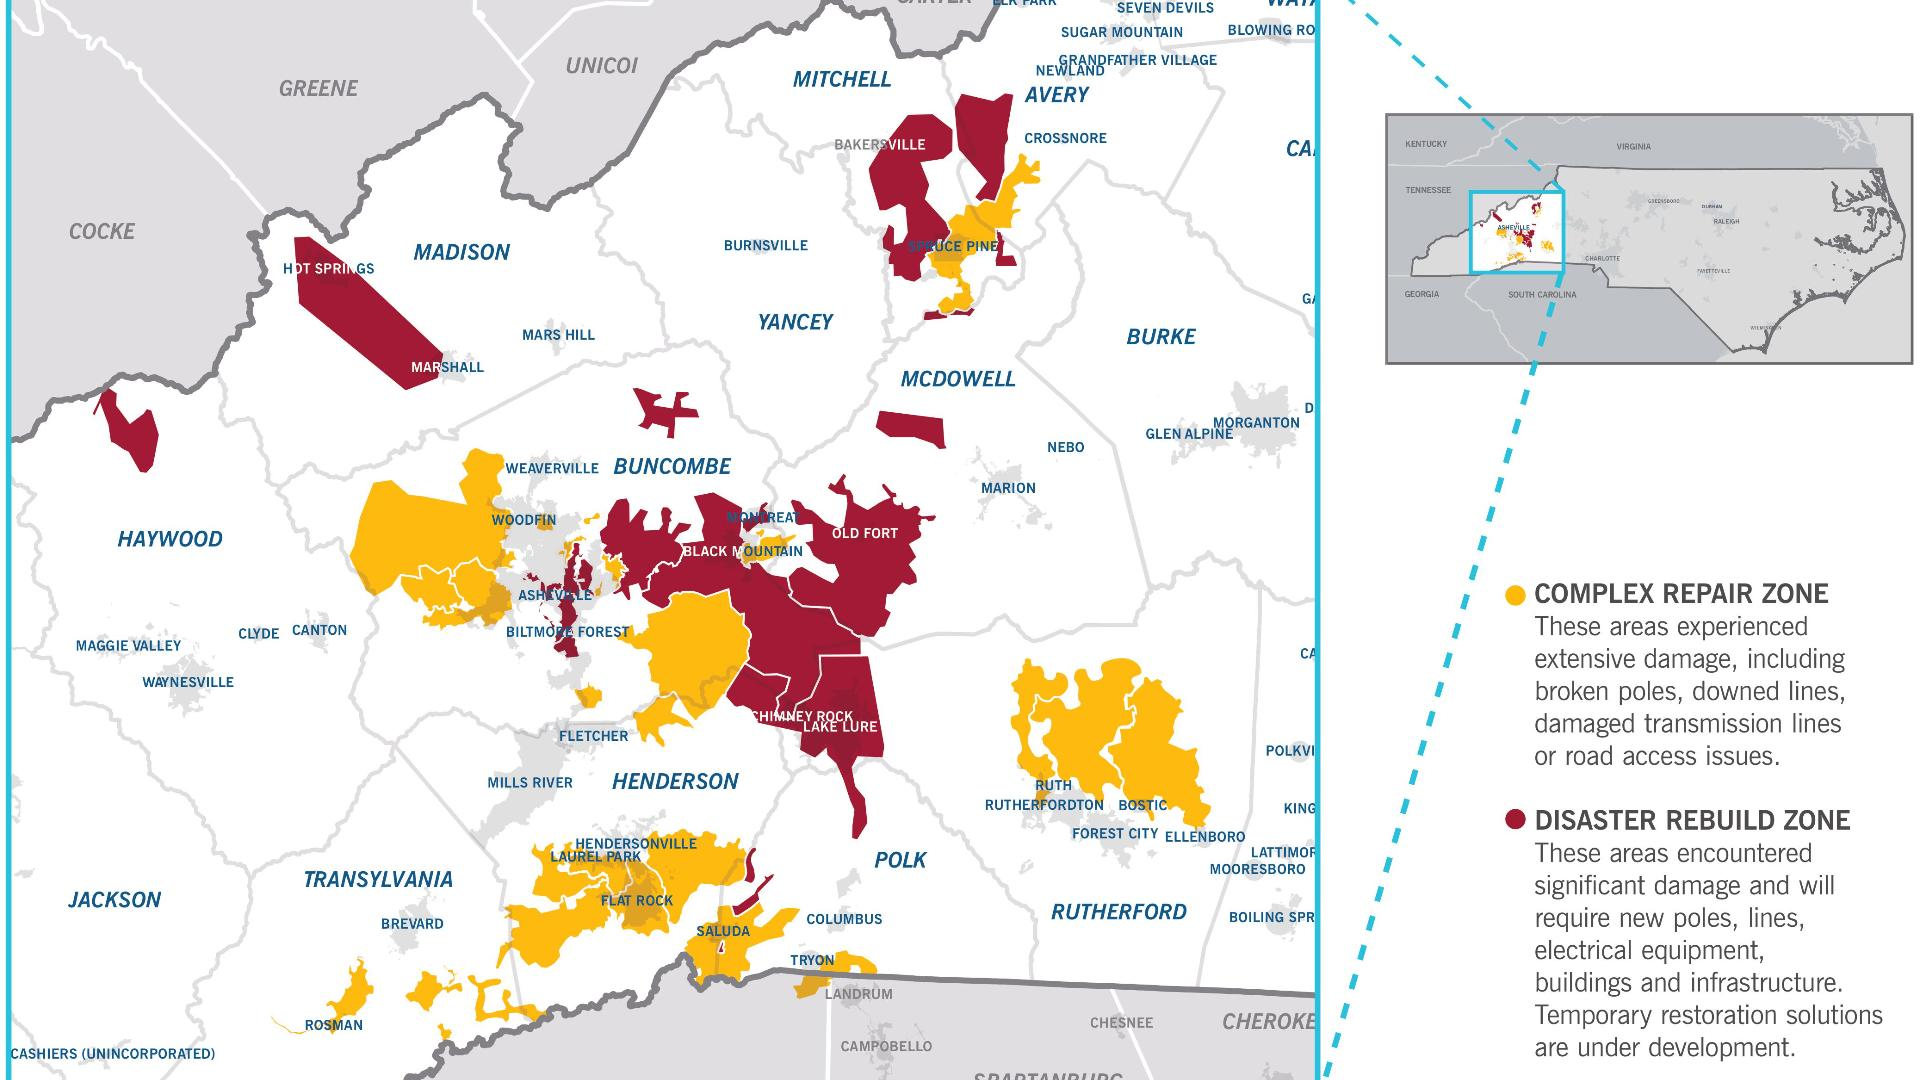

In [6]:
# Plotly
nc_geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"

# Assuming 'value' is linked to county names or FIPS codes
fig = px.choropleth(counties, 
                    geojson=nc_geojson, 
                    locations='County', 
                    color='article', 
                    featureidkey='properties.NAME',  # Adjust to match GeoJSON property
                    color_continuous_scale="Blues")
fig.update_geos(fitbounds="locations", visible=False)
fig.show()